In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

import ipdb
import os
import bda_utils

# Load data

In [2]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:,8:9]
Xt = Xt[:,8:9]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

In [63]:
label_seq_len = 7
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 3
layers = 1
lamb = 2
MU = 0.7
bda_dim = label_seq_len-4
kernel_type = 'linear'

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb,
    'MU': MU,
    'bda_dim':bda_dim,
    'kernel_type':kernel_type}

hyper = pd.DataFrame(hyper, index=['Values'])
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb,MU,bda_dim,kernel_type
Values,1,1,7,12,4,3,1,2,0.7,3,linear


In [64]:
Xs = Xs[:96, :]

# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)
Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(78, 12, 1)
(78, 1, 1)
(462, 12, 1)
(462, 1, 1)


In [65]:

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):

#     bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
#     Xs_new, Xt_new, A = bda.fit(
#         Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
#     )  # input shape: ns, n_feature | ns, n_label_feature
    Xs_new = Xs_3d[:, :, 0]
    Xt_new = Xt_3d[:, :, 0]

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(Xs_3d.shape[0]):, :]
    Xt_train = Xt_new.copy()[:int(Xs_3d.shape[0]), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(Xs_3d.shape[0]):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(Xs_3d.shape[0]), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))


In [66]:
print(Xs_train.shape)
print(Ys_train.shape)
print(Xt_valid.shape)
print(Xt_train.shape)
print(Yt_valid.shape)
print(Yt_train.shape)

(78, 12)
(78, 1)
(384, 12)
(78, 12)
(384, 1)
(78, 1)


# LSTM

In [67]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='relu'))

# Training on target data

In [68]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(
    Xt_train[:, :, np.newaxis], Yt_train[:, :, np.newaxis],
    epochs=500, batch_size=128, validation_data=(Xt_valid[:, :, np.newaxis], Yt_valid[:, :, np.newaxis]),
    verbose=2, shuffle=True
)


Epoch 1/1000
1/1 - 8s - loss: 0.3465 - val_loss: 0.2334
Epoch 2/1000
1/1 - 0s - loss: 0.3265 - val_loss: 0.2353
Epoch 3/1000
1/1 - 0s - loss: 0.3068 - val_loss: 0.2372
Epoch 4/1000
1/1 - 0s - loss: 0.2875 - val_loss: 0.2390
Epoch 5/1000
1/1 - 0s - loss: 0.2689 - val_loss: 0.2406
Epoch 6/1000
1/1 - 0s - loss: 0.2510 - val_loss: 0.2422
Epoch 7/1000
1/1 - 0s - loss: 0.2340 - val_loss: 0.2438
Epoch 8/1000
1/1 - 0s - loss: 0.2182 - val_loss: 0.2452
Epoch 9/1000
1/1 - 0s - loss: 0.2036 - val_loss: 0.2466
Epoch 10/1000
1/1 - 0s - loss: 0.1906 - val_loss: 0.2478
Epoch 11/1000
1/1 - 0s - loss: 0.1791 - val_loss: 0.2490
Epoch 12/1000
1/1 - 0s - loss: 0.1692 - val_loss: 0.2500
Epoch 13/1000
1/1 - 0s - loss: 0.1610 - val_loss: 0.2509
Epoch 14/1000
1/1 - 0s - loss: 0.1544 - val_loss: 0.2517
Epoch 15/1000
1/1 - 0s - loss: 0.1492 - val_loss: 0.2523
Epoch 16/1000
1/1 - 0s - loss: 0.1453 - val_loss: 0.2528
Epoch 17/1000
1/1 - 0s - loss: 0.1425 - val_loss: 0.2531
Epoch 18/1000
1/1 - 0s - loss: 0.1405 - 

1/1 - 0s - loss: 0.1068 - val_loss: 0.1700
Epoch 145/1000
1/1 - 0s - loss: 0.1067 - val_loss: 0.1696
Epoch 146/1000
1/1 - 0s - loss: 0.1067 - val_loss: 0.1693
Epoch 147/1000
1/1 - 0s - loss: 0.1066 - val_loss: 0.1690
Epoch 148/1000
1/1 - 0s - loss: 0.1065 - val_loss: 0.1688
Epoch 149/1000
1/1 - 0s - loss: 0.1064 - val_loss: 0.1685
Epoch 150/1000
1/1 - 0s - loss: 0.1064 - val_loss: 0.1682
Epoch 151/1000
1/1 - 0s - loss: 0.1063 - val_loss: 0.1679
Epoch 152/1000
1/1 - 0s - loss: 0.1062 - val_loss: 0.1676
Epoch 153/1000
1/1 - 0s - loss: 0.1062 - val_loss: 0.1674
Epoch 154/1000
1/1 - 0s - loss: 0.1061 - val_loss: 0.1671
Epoch 155/1000
1/1 - 0s - loss: 0.1061 - val_loss: 0.1669
Epoch 156/1000
1/1 - 0s - loss: 0.1060 - val_loss: 0.1666
Epoch 157/1000
1/1 - 0s - loss: 0.1060 - val_loss: 0.1664
Epoch 158/1000
1/1 - 0s - loss: 0.1059 - val_loss: 0.1661
Epoch 159/1000
1/1 - 0s - loss: 0.1058 - val_loss: 0.1659
Epoch 160/1000
1/1 - 0s - loss: 0.1058 - val_loss: 0.1657
Epoch 161/1000
1/1 - 0s - los

Epoch 286/1000
1/1 - 0s - loss: 0.0972 - val_loss: 0.1152
Epoch 287/1000
1/1 - 0s - loss: 0.0972 - val_loss: 0.1150
Epoch 288/1000
1/1 - 0s - loss: 0.0972 - val_loss: 0.1147
Epoch 289/1000
1/1 - 0s - loss: 0.0972 - val_loss: 0.1145
Epoch 290/1000
1/1 - 0s - loss: 0.0971 - val_loss: 0.1142
Epoch 291/1000
1/1 - 0s - loss: 0.0971 - val_loss: 0.1140
Epoch 292/1000
1/1 - 0s - loss: 0.0971 - val_loss: 0.1138
Epoch 293/1000
1/1 - 0s - loss: 0.0971 - val_loss: 0.1135
Epoch 294/1000
1/1 - 0s - loss: 0.0970 - val_loss: 0.1133
Epoch 295/1000
1/1 - 0s - loss: 0.0970 - val_loss: 0.1130
Epoch 296/1000
1/1 - 0s - loss: 0.0970 - val_loss: 0.1128
Epoch 297/1000
1/1 - 0s - loss: 0.0970 - val_loss: 0.1126
Epoch 298/1000
1/1 - 0s - loss: 0.0970 - val_loss: 0.1123
Epoch 299/1000
1/1 - 0s - loss: 0.0969 - val_loss: 0.1121
Epoch 300/1000
1/1 - 0s - loss: 0.0969 - val_loss: 0.1118
Epoch 301/1000
1/1 - 0s - loss: 0.0969 - val_loss: 0.1116
Epoch 302/1000
1/1 - 0s - loss: 0.0968 - val_loss: 0.1114
Epoch 303/1000

1/1 - 0s - loss: 0.0888 - val_loss: 0.0804
Epoch 428/1000
1/1 - 0s - loss: 0.0885 - val_loss: 0.0802
Epoch 429/1000
1/1 - 0s - loss: 0.0883 - val_loss: 0.0800
Epoch 430/1000
1/1 - 0s - loss: 0.0881 - val_loss: 0.0798
Epoch 431/1000
1/1 - 0s - loss: 0.0879 - val_loss: 0.0796
Epoch 432/1000
1/1 - 0s - loss: 0.0878 - val_loss: 0.0795
Epoch 433/1000
1/1 - 0s - loss: 0.0877 - val_loss: 0.0793
Epoch 434/1000
1/1 - 0s - loss: 0.0876 - val_loss: 0.0792
Epoch 435/1000
1/1 - 0s - loss: 0.0875 - val_loss: 0.0791
Epoch 436/1000
1/1 - 0s - loss: 0.0874 - val_loss: 0.0791
Epoch 437/1000
1/1 - 0s - loss: 0.0872 - val_loss: 0.0790
Epoch 438/1000
1/1 - 0s - loss: 0.0870 - val_loss: 0.0790
Epoch 439/1000
1/1 - 0s - loss: 0.0868 - val_loss: 0.0791
Epoch 440/1000
1/1 - 0s - loss: 0.0866 - val_loss: 0.0791
Epoch 441/1000
1/1 - 0s - loss: 0.0865 - val_loss: 0.0792
Epoch 442/1000
1/1 - 0s - loss: 0.0864 - val_loss: 0.0793
Epoch 443/1000
1/1 - 0s - loss: 0.0863 - val_loss: 0.0794
Epoch 444/1000
1/1 - 0s - los

Epoch 569/1000
1/1 - 0s - loss: 0.0819 - val_loss: 0.0809
Epoch 570/1000
1/1 - 0s - loss: 0.0819 - val_loss: 0.0808
Epoch 571/1000
1/1 - 0s - loss: 0.0819 - val_loss: 0.0808
Epoch 572/1000
1/1 - 0s - loss: 0.0819 - val_loss: 0.0807
Epoch 573/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0807
Epoch 574/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0806
Epoch 575/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0806
Epoch 576/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0805
Epoch 577/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0805
Epoch 578/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0805
Epoch 579/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0804
Epoch 580/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0804
Epoch 581/1000
1/1 - 0s - loss: 0.0818 - val_loss: 0.0804
Epoch 582/1000
1/1 - 0s - loss: 0.0817 - val_loss: 0.0803
Epoch 583/1000
1/1 - 0s - loss: 0.0817 - val_loss: 0.0803
Epoch 584/1000
1/1 - 0s - loss: 0.0817 - val_loss: 0.0803
Epoch 585/1000
1/1 - 0s - loss: 0.0817 - val_loss: 0.0803
Epoch 586/1000

1/1 - 0s - loss: 0.0761 - val_loss: 0.2039
Epoch 711/1000
1/1 - 0s - loss: 0.0760 - val_loss: 0.2075
Epoch 712/1000
1/1 - 0s - loss: 0.0760 - val_loss: 0.2107
Epoch 713/1000
1/1 - 0s - loss: 0.0759 - val_loss: 0.2136
Epoch 714/1000
1/1 - 0s - loss: 0.0759 - val_loss: 0.2162
Epoch 715/1000
1/1 - 0s - loss: 0.0758 - val_loss: 0.2185
Epoch 716/1000
1/1 - 0s - loss: 0.0758 - val_loss: 0.2206
Epoch 717/1000
1/1 - 0s - loss: 0.0757 - val_loss: 0.2224
Epoch 718/1000
1/1 - 0s - loss: 0.0757 - val_loss: 0.2240
Epoch 719/1000
1/1 - 0s - loss: 0.0756 - val_loss: 0.2254
Epoch 720/1000
1/1 - 0s - loss: 0.0756 - val_loss: 0.2265
Epoch 721/1000
1/1 - 0s - loss: 0.0755 - val_loss: 0.2274
Epoch 722/1000
1/1 - 0s - loss: 0.0755 - val_loss: 0.2281
Epoch 723/1000
1/1 - 0s - loss: 0.0755 - val_loss: 0.2286
Epoch 724/1000
1/1 - 0s - loss: 0.0754 - val_loss: 0.2288
Epoch 725/1000
1/1 - 0s - loss: 0.0754 - val_loss: 0.2288
Epoch 726/1000
1/1 - 0s - loss: 0.0753 - val_loss: 0.2286
Epoch 727/1000
1/1 - 0s - los

Epoch 852/1000
1/1 - 0s - loss: 0.0180 - val_loss: 1.0932
Epoch 853/1000
1/1 - 0s - loss: 0.0179 - val_loss: 1.0734
Epoch 854/1000
1/1 - 0s - loss: 0.0177 - val_loss: 1.0460
Epoch 855/1000
1/1 - 0s - loss: 0.0174 - val_loss: 1.0177
Epoch 856/1000
1/1 - 0s - loss: 0.0173 - val_loss: 0.9949
Epoch 857/1000
1/1 - 0s - loss: 0.0173 - val_loss: 0.9806
Epoch 858/1000
1/1 - 0s - loss: 0.0171 - val_loss: 0.9733
Epoch 859/1000
1/1 - 0s - loss: 0.0169 - val_loss: 0.9681
Epoch 860/1000
1/1 - 0s - loss: 0.0168 - val_loss: 0.9593
Epoch 861/1000
1/1 - 0s - loss: 0.0168 - val_loss: 0.9433
Epoch 862/1000
1/1 - 0s - loss: 0.0167 - val_loss: 0.9198
Epoch 863/1000
1/1 - 0s - loss: 0.0166 - val_loss: 0.8922
Epoch 864/1000
1/1 - 0s - loss: 0.0165 - val_loss: 0.8654
Epoch 865/1000
1/1 - 0s - loss: 0.0164 - val_loss: 0.8429
Epoch 866/1000
1/1 - 0s - loss: 0.0164 - val_loss: 0.8259
Epoch 867/1000
1/1 - 0s - loss: 0.0163 - val_loss: 0.8123
Epoch 868/1000
1/1 - 0s - loss: 0.0162 - val_loss: 0.7986
Epoch 869/1000

1/1 - 0s - loss: 0.0112 - val_loss: 0.0308
Epoch 994/1000
1/1 - 0s - loss: 0.0112 - val_loss: 0.0318
Epoch 995/1000
1/1 - 0s - loss: 0.0111 - val_loss: 0.0328
Epoch 996/1000
1/1 - 0s - loss: 0.0111 - val_loss: 0.0338
Epoch 997/1000
1/1 - 0s - loss: 0.0111 - val_loss: 0.0349
Epoch 998/1000
1/1 - 0s - loss: 0.0111 - val_loss: 0.0360
Epoch 999/1000
1/1 - 0s - loss: 0.0110 - val_loss: 0.0372
Epoch 1000/1000
1/1 - 0s - loss: 0.0110 - val_loss: 0.0384


# Visualization

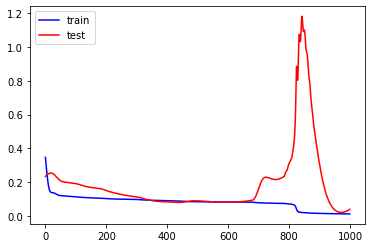

In [69]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

# Evaluation

In [70]:
g_t = Yt_valid.flatten()
pred = model.predict(Xt_valid[:, :, np.newaxis]).flatten()

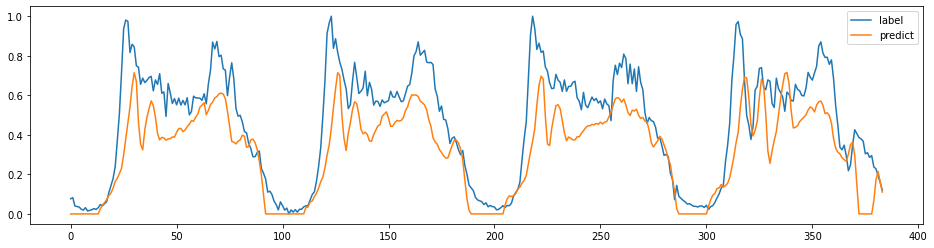

In [71]:
plt.figure(figsize=[16,4])
plt.plot(g_t, label='label')
plt.plot(pred, label='predict')
plt.legend()

bda_utils.save_np(g_t, './runs_base/base_data_plot/g_t_base_LSTM.csv')
bda_utils.save_np(pred, './runs_base/base_data_plot/pred_base_LSTM.csv')

In [72]:
print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.smape_loss_func(pred, g_t, 0))

0.21374672870856398
0.35807326890606406
